In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import ListedColormap 
from matplotlib import gridspec
import scienceplots
plt.style.use(['science', 'grid'])
textwidth = 3.31314
aspect_ratio = 6/8
width = textwidth
height = width * aspect_ratio

In [ ]:
from pathlib import Path 
import sys 
import os 
PATH = Path.cwd() 
sys.path.insert(0, str(Path(PATH).parent))

model_save_dir = str(Path(PATH).parent) + '/saved_models'
to_load, model_num = 'dual-simple-3', 174
model_path = os.path.join(model_save_dir, f'{to_load}/{model_num}.pt')

from configs.parsing import get_config_file, set_model_config_based_on_dataset
import argparse 

config_filename = os.path.join(model_save_dir, f'{to_load}/config.json')
config_dict = get_config_file(config_filename)
print(config_dict)
d = {**config_dict}
args = argparse.Namespace(**d)

import data 
import models 
data_interface = data.DatasetInterface(args.data.pop('return_type'), **args.data)
args = set_model_config_based_on_dataset(args, data_interface)
model_interface = getattr(models, args.model.pop('object'))(**args.model)

import torch 
if isinstance(model_interface, torch.nn.Module): 
    state_dict = torch.jit.load(model_path, map_location=torch.device('cpu'))
    model_interface.load_state_dict(state_dict.state_dict())
    print('Loaded Module from state_dict')
elif isinstance(model_interface, torch.jit.TorchScript): 
    import io 
    with open(model_path, 'rb') as f:
        buffer = io.BytesIO(f.read())
    buffer.seek(0)
    loaded_module = torch.jit.load(buffer, map_location=torch.device('cpu'))
    model_interface.load_state_dict(loaded_module.state_dict())
    print('Loaded Module from jit')

model_interface = model_interface.eval()

In [17]:
from common.interfaces import D, M
m_interface: M = model_interface.observational.model_interface
d_interface: D = model_interface.data_interface

train_indicies = data_interface.train_dataset.indices
valid_indicies = data_interface.valid_dataset.indices
test_indicies = data_interface.test_dataset.indices
shot_numbers = data_interface.dataset.shot_numbers
actions_name_list = data_interface.dataset.filter_mps_names
train_shots, valid_shots, test_shots = [[shot_numbers[t] for t in idxs] for idxs in [train_indicies, valid_indicies, test_indicies]]
print(actions_name_list)

['IpiFP', 'D_tot', 'k', 'delRoben', 'delRuntn', 'ahor', 'q95', 'P_TOT', 'aspect_ratio']


In [18]:
def shot_prediction(queried_shot: int = 35100):
    # Should return all of the plots for a single shot
    rel_idx = shot_numbers.index(int(queried_shot))
    *batch, shot_num = data_interface.dataset.__getitem__(rel_idx)
    batch_on_device = tuple(item.float().unsqueeze(1) for item in batch)
    if m_interface in [M.DIVA, M.vae]: 
        observations, actions, radii, time = batch_on_device
        actions_cond, actions_cond_recon = [], []
    elif m_interface in  [None]: 
        observations, actions, radii, time, actions_cond = batch_on_device 
    batch_terminus = time > 0

    
    with torch.no_grad():
        observations_out = model_interface.forward_observational(observations, actions)
    
    if m_interface == M.DIVA: 
        # observation_reconstructions, [posterior_state, posterior_state_locs, posterior_state_scales], [posterior_state_c, posterior_state_locs_c, posterior_state_scales_c], [posterior_state_not_c, posterior_state_locs_not_c, posterior_state_scales_not_c], [prior_state, prior_state_locs, prior_state_scales], action_reconstructions = out
        [observation_reconstructions_encoder, action_reconstructions_encoder, [posterior_state, posterior_state_locs, posterior_state_scales]], [observation_reconstructions_prior, action_reconstructions_prior, [prior_state, prior_state_locs, prior_state_scales]] = observations_out # model_interface.inference_all(observations, actions)
    elif m_interface == M.vae: 
        observation_reconstructions_encoder, [posterior_state, posterior_state_locs, posterior_state_scales] = observations_out


    with torch.no_grad(): 
        observations_trans, state_trans, [state_mu_trans, state_std_devs_trans] = model_interface.pulse_inference([posterior_state, posterior_state_locs, posterior_state_scales], actions[:-1])
        prior_state, prior_state_locs, prior_state_scales = torch.clone(posterior_state), torch.clone(posterior_state_locs), torch.clone(posterior_state_scales)
        prior_state[1:] =  state_trans
        prior_state_locs[1:] =  state_mu_trans
        prior_state_scales[1:] =  state_std_devs_trans

        observation_reconstructions_trans = torch.clone(observation_reconstructions_encoder)
        observation_reconstructions_trans[1:] = observations_trans

    time = time[batch_terminus].numpy()
    data_x = radii[0].cpu().numpy()[0]
    if m_interface == M.DIVA: 
        latent_space_to_return = [[posterior_state, posterior_state_locs, posterior_state_scales], [prior_state, prior_state_locs, prior_state_scales]] 
        observations_to_return = [data_interface.dataset.denorm_profs(obs)[batch_terminus] for obs in [observations, observation_reconstructions_encoder, observation_reconstructions_prior]]
        actions_to_return = [data_interface.dataset.denorm_mps(acts) for acts in [actions, action_reconstructions_encoder, action_reconstructions_prior]]
    elif m_interface == M.vae: 
        latent_space_to_return = [ [arr[batch_terminus] for arr in group] for group in [[posterior_state, posterior_state_locs, posterior_state_scales], [prior_state, prior_state_locs, prior_state_scales]]]
        observations_to_return = [data_interface.dataset.denorm_profs(obs)[batch_terminus] for obs in [observations, observation_reconstructions_encoder, observation_reconstructions_trans]]
        actions_to_return = [data_interface.dataset.denorm_mps(acts)[batch_terminus] for acts in [actions]]
    else: 
        latent_space_to_return, observations_to_return, actions_to_return = [], [], []


    
    return observations_to_return, actions_to_return, time, data_x, batch_terminus, latent_space_to_return



mp_name_dict = {'IpiFP': {'latex': r'$I_\text{P}$'}, 
                'D_tot': {'latex':r'$D_\text{TOT}$'}, 
                'k': {'latex': r'$\kappa$'}, 
                'delRoben': {'latex': r'$\delta_\text{oben}$'}, 
                'delRuntn': {'latex': r'$\delta_{\text{unt}}$'}, 
                'ahor': {'latex':'a'}, 
                'q95': {'latex': r'$q_{95}$'}, 
                'P_TOT/P_LH': {'latex': r'$P_\text{TOT}/P_\text{LH}$'},
                'P_TOT': {'latex': r'$P_\text{TOT}$'}, 
                'aspect_ratio': {'latex': 'A'}}


In [19]:
shot_num = train_shots[2]
observation_info, action_info, time, radius, batch_terminal, latent_space_information = shot_prediction(shot_num)

33043


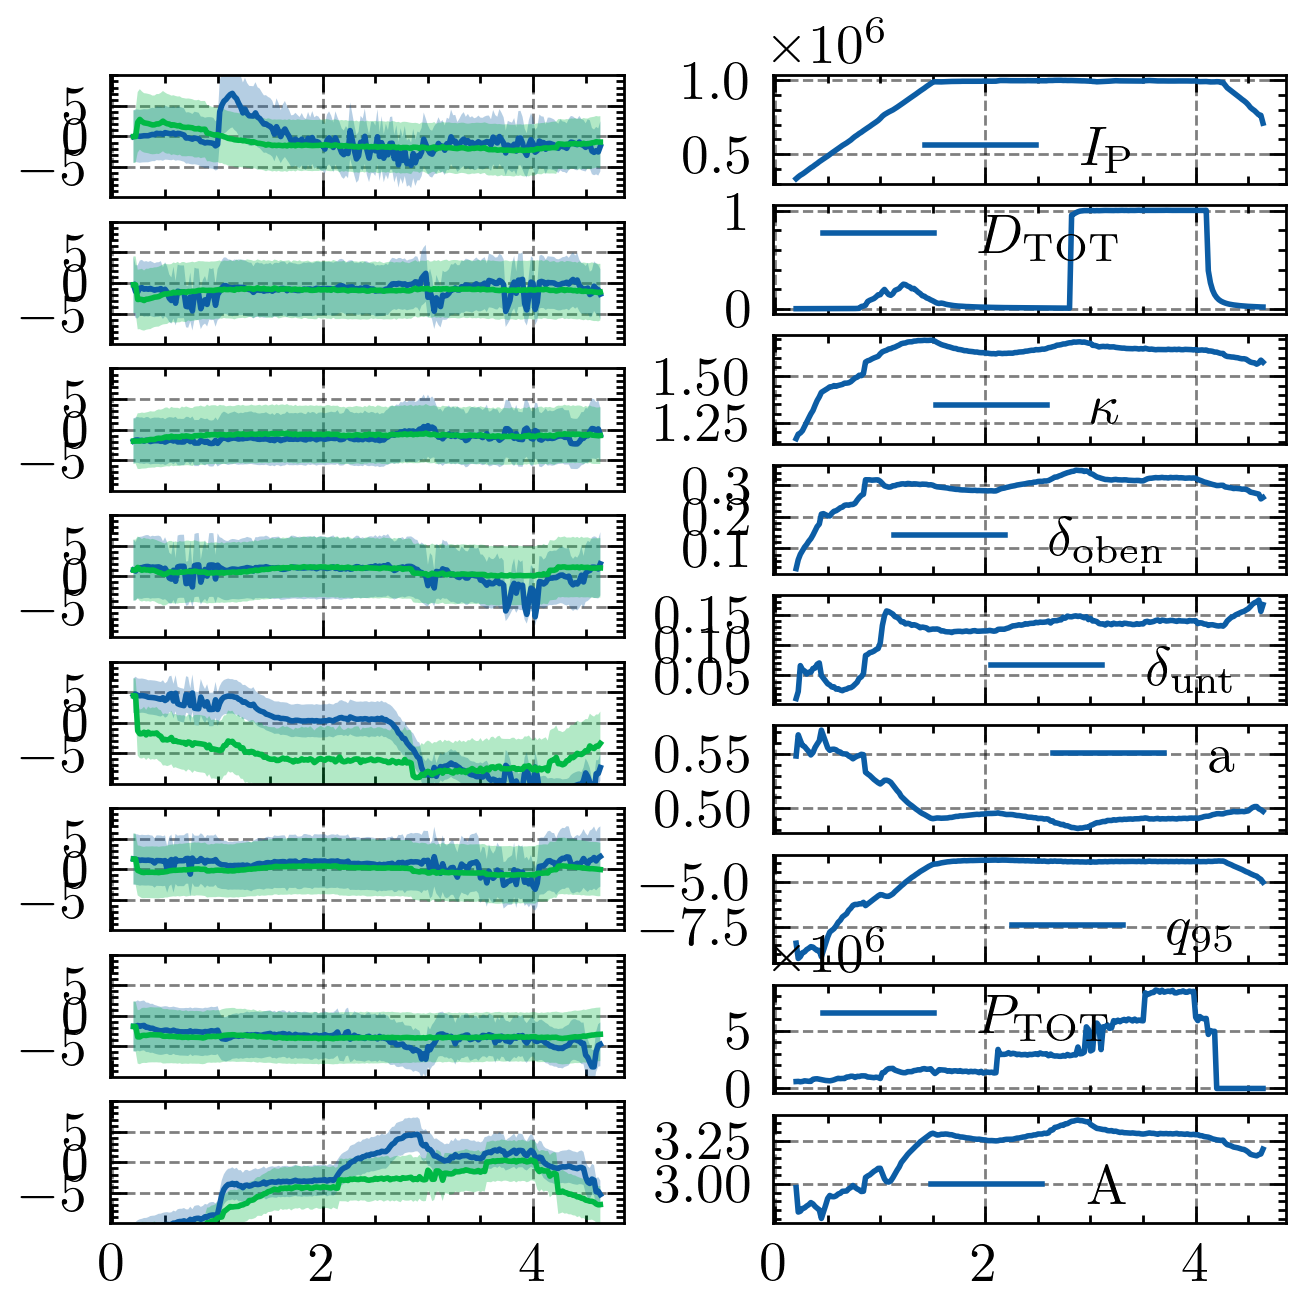

In [20]:
""" 
ne_width ~ 1 / ne_ped_height
"""

shotno = valid_shots[7]
print(shotno)
observation_info, action_info, time, radius, batch_terminal, latent_space_information = shot_prediction(shotno)

data_actions = action_info[0]
[_, post_loc, post_scale], [_, prior_loc, prior_scale] = latent_space_information
data_true, data_pred_obs, data_pred_trans = observation_info
data_time = time 

fig = plt.figure( figsize=(width, 1.5*height), dpi=400)
subfigs = fig.subfigures(1, 2, wspace=0.07)

axs = subfigs[0].subplots(post_loc.shape[-1], sharey=True, sharex=True)
# fig, axs = plt.subplots(post_loc.shape[-1], figsize=(width, 1.5*height), dpi=400)

for i in range(post_loc.shape[-1]): 
    ax = axs[i]
    for loc, scale in [[post_loc, post_scale], [prior_loc, prior_scale]]:
        ax.plot(data_time, loc[:, i])
        ax.fill_between(data_time, loc[:, i] + scale[:, i], loc[:, i] - scale[:, i], alpha=0.3)
    
    ax.label_outer()
    ax.set_ylim(-10, 10)
    ax.set_yticks([-5, 0, 5])
mp_axs = subfigs[1].subplots(data_actions.shape[-1], sharex=True)
for i in range(data_actions.shape[-1]): 
    ax = mp_axs[i]
    ax.plot(data_time, data_actions[:, i], label=mp_name_dict[actions_name_list[i]]['latex'])
    ax.legend(frameon=False)
    

In [11]:


def to_plot(data_true, data_pred, data_time, data_x, title: str, ): 
    
    hsv_modified = mpl.colormaps.get_cmap('Spectral')
    crange = np.flip(np.linspace(0.1, 1.0, 256), axis=0)
    newcmp = ListedColormap(hsv_modified(crange))
    d_scalar = 1e-19
    t_scalar = 0.001
    fig = plt.figure(figsize=(width, height), dpi=400)
    gs= gridspec.GridSpec(3, 2, height_ratios=[0.5, 4, 4])
    cax_n = plt.subplot(gs[0, 0])
    cax_t = plt.subplot(gs[0, 1])
    ne_ax = plt.subplot(gs[1, 0])
    ne2_ax = plt.subplot(gs[2, 0])
    te_ax = plt.subplot(gs[1, 1])
    te2_ax = plt.subplot(gs[2, 1])


    fig.suptitle(f'AUG \#{shotno} {title}', y=1.0)
    # fig.subplots_adjust(top=0.92)
    # (ne_ax, te_ax), (ne2_ax, te2_ax) = fig.subplots(2, 2)
    ne_minmin, ne_maxmax = min(abs(np.min(data_pred[:, 0, :].numpy()*d_scalar)), abs(np.min(data_true[:, 0, :].numpy()*d_scalar))), max(np.max(data_pred[:, 0, :].numpy()*d_scalar), np.max(data_true[:, 0, :].numpy()*d_scalar))
    te_minmin, te_maxmax = min(np.min(data_true[:, 1, :].numpy()*t_scalar), np.min(data_pred[:, 1, :].numpy()*t_scalar)), max(np.max(data_true[:, 1, :].numpy()*t_scalar), np.max(data_pred[:, 1, :].numpy()*t_scalar))

    ne_plot = ne_ax.imshow(np.swapaxes(data_true[:, 0, :].numpy()*d_scalar, 0, 1), interpolation='nearest', vmin=ne_minmin, vmax=ne_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    cbars = []
    cbar = fig.colorbar(ne_plot, cax=cax_n, label=' $n_e$ ($10^{19}$m$^{-3}$)', orientation='horizontal', ) # , aspect=aspect, shrink=shrink, pad=pad
    cbars.append(cbar)
    # cbar.ax.xaxis.set_label_position('top')
    # cbar.ax.xaxis.set_ticks_position('top')
    te_plot = te_ax.imshow(np.swapaxes(data_true[:, 1, :].numpy()*t_scalar, 0, 1), interpolation='nearest', vmin=te_minmin, vmax=te_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    cbar = fig.colorbar(te_plot, cax=cax_t, label=' $T_e$(keV)', orientation='horizontal') # , aspect=aspect, shrink=shrink, pad=pad
    cbars.append(cbar)

    for cbar in cbars: 
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))
        cbar.ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

    ne2_plot = ne2_ax.imshow(np.swapaxes(data_pred[:, 0, :].numpy()*d_scalar, 0, 1), interpolation='nearest', vmin=ne_minmin, vmax=ne_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    te2_plot = te2_ax.imshow(np.swapaxes(data_pred[:, 1, :].numpy()*t_scalar, 0, 1), interpolation='nearest', vmin=te_minmin, vmax=te_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    fig.subplots_adjust(hspace=0.0)
    # ne_ax.set_title(' $n_e$ (m$^{-3}$)')
    # te_ax.set_title(' $T_e$ (eV)')
    xticks = np.array(ne_ax.get_xticks())
    xticks = np.array([int(x) for x in xticks if 0 <= x < time.shape[0]]) # + [data_time.shape[0] - 1]

    yticks = np.array(ne_ax.get_yticks())
    yticks = np.array([int(y) for y in yticks if 0 <= y < data_x.shape[0]]) # + [data_x.shape[0] - 1]

    for ax in [ne_ax, te_ax, ne2_ax, te2_ax]:
        ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(3))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))    
        ax.label_outer()
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        # set_ticks(ax, xticks, data_time, yticks, data_x, x_name='time (s)', y_name=r'$\rho$', )  # set tick labels
        ax.set_yticks([0.0, 0.5, 0.9])


    te_ax.set_yticklabels([])
    te_ax.set_xticklabels([])
    ne_ax.set_xticklabels([])
    ne2_ax.set_xlabel('time (s)')
    te2_ax.set_xlabel('time (s)')
    ne_ax.set_ylabel('True \n' +  r'$\rho$')
    ne2_ax.set_ylabel('Recon. \n' r'$\rho$')

    fig.subplots_adjust(hspace=0.11, top=0.8, wspace=0.3)

    plt.show()


    loss = torch.nn.functional.l1_loss(data_true, data_pred_obs, reduction='none')
    loss[:, 0] = loss[:, 0]*1e-19
    loss[:, 1] = loss[:, 1] / 1000.0
    print('Density Mean', loss[:, 0].mean().item(), loss[:, 0].std().item())
    print('Tempearutre Mean', loss[:, 1].mean().item(), loss[:, 1].std().item())
    for rho in [0.0, 0.5, 0.9, 1.0]: 
        rho_idx = np.argmin(abs(data_x - rho))
        print(f'Density {rho}', loss[:, 0, rho_idx].mean().item(), loss[:, 0, rho_idx].std().item())
        print(f'Temperature {rho}', loss[:, 1, rho_idx].mean().item(), loss[:, 1, rho_idx].std().item())


def to_plot2(data_true, data_pred, data_time, data_x, title: str, ): 
    hsv_modified = mpl.colormaps.get_cmap('Spectral')
    crange = np.flip(np.linspace(0.1, 1.0, 256), axis=0)
    newcmp = ListedColormap(hsv_modified(crange))
    d_scalar = 1e-19
    t_scalar = 0.001
    fig = plt.figure(figsize=(width, height), dpi=400)
    fig.suptitle(f'AUG \#{shotno} {title}', y=1.05)
    gs= gridspec.GridSpec(4, 2, height_ratios=[0.5, 4, 4, 4])
    cax_n = plt.subplot(gs[0, 0])
    cax_t = plt.subplot(gs[0, 1])
    ne_ax = plt.subplot(gs[1, 0])
    ne2_ax = plt.subplot(gs[2, 0])
    ne3_ax = plt.subplot(gs[3, 0])
    te_ax = plt.subplot(gs[1, 1])
    te2_ax = plt.subplot(gs[2, 1])
    te3_ax = plt.subplot(gs[3, 1])

    ne_minmin, ne_maxmax = min(abs(np.min(data_pred[:, 0, :].numpy()*d_scalar)), abs(np.min(data_true[:, 0, :].numpy()*d_scalar))), max(np.max(data_pred[:, 0, :].numpy()*d_scalar), np.max(data_true[:, 0, :].numpy()*d_scalar))
    te_minmin, te_maxmax = min(np.min(data_true[:, 1, :].numpy()*t_scalar), np.min(data_pred[:, 1, :].numpy()*t_scalar)), max(np.max(data_true[:, 1, :].numpy()*t_scalar), np.max(data_pred[:, 1, :].numpy()*t_scalar))

    ne_plot = ne_ax.imshow(np.swapaxes(data_true[:, 0, :].numpy()*d_scalar, 0, 1), interpolation='nearest', vmin=ne_minmin, vmax=ne_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    cbars = []
    cbar = fig.colorbar(ne_plot, cax=cax_n, label=' $n_e$ ($10^{19}$m$^{-3}$)', orientation='horizontal', ) # , aspect=aspect, shrink=shrink, pad=pad
    cbars.append(cbar)
    te_plot = te_ax.imshow(np.swapaxes(data_true[:, 1, :].numpy()*t_scalar, 0, 1), interpolation='nearest', vmin=te_minmin, vmax=te_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    cbar = fig.colorbar(te_plot, cax=cax_t, label=' $T_e$(keV)', orientation='horizontal') # , aspect=aspect, shrink=shrink, pad=pad
    cbars.append(cbar)
    for cbar in cbars: 
        cbar.ax.xaxis.set_label_position('top')
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))
        cbar.ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))

    ne2_plot = ne2_ax.imshow(np.swapaxes(data_pred[:, 0, :].numpy()*d_scalar, 0, 1), interpolation='nearest', vmin=ne_minmin, vmax=ne_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    te2_plot = te2_ax.imshow(np.swapaxes(data_pred[:, 1, :].numpy()*t_scalar, 0, 1), interpolation='nearest', vmin=te_minmin, vmax=te_maxmax, cmap=newcmp, aspect='auto', extent=[data_time.min(), data_time.max(), data_x.max(), data_x.min()])
    fig.subplots_adjust(hspace=0.0)
    xticks = np.array(ne_ax.get_xticks())
    xticks = np.array([int(x) for x in xticks if 0 <= x < data_time.shape[0]]) # + [data_time.shape[0] - 1]

    yticks = np.array(ne_ax.get_yticks())
    yticks = np.array([int(y) for y in yticks if 0 <= y < data_x.shape[0]]) # + [data_x.shape[0] - 1]


    rho_lns = []
    rho_lns_pred = []
    for rho in [0.0, 0.5, 0.9]: 
        rho_idx = np.argmin(abs(data_x - rho))
        ne_ln, = ne3_ax.plot(data_time, data_true[:, 0, rho_idx]*d_scalar, label=f'{rho:.1}', alpha=0.7)
        ne_ln_pred, = ne3_ax.plot(data_time, data_pred[:, 0, rho_idx]*d_scalar, ls='dotted', c=ne_ln.get_color())
        rho_lns.append(ne_ln)
        rho_lns_pred.append(ne_ln_pred)
        te_ln, = te3_ax.plot(data_time, data_true[:, 1, rho_idx]*t_scalar, label=f'{rho:.1}', alpha=0.7)
        te3_ax.plot(data_time, data_pred[:, 1, rho_idx]*t_scalar, ls='dotted', c=te_ln.get_color())

    for ax in [ne3_ax, te3_ax]: 
        ax.set_xlim(data_time.min(), data_time.max())
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))  
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        
        ax.yaxis.grid(False)
    for cbar, ax in zip(cbars, [ne3_ax, te3_ax]): 
        new_yticks= cbar.get_ticks()
        ax.yaxis.set_ticks(new_yticks)
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
    for ax in [ne_ax, te_ax, ne2_ax, te2_ax]:
        ax.yaxis.set_major_locator(mpl.ticker.LinearLocator(3))
        ax.xaxis.set_major_locator(mpl.ticker.LinearLocator(3))    
        ax.label_outer()
        ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        ax.set_yticks([0.0, 0.5, 0.9])
    te_ax.set_yticklabels([])
    te_ax.set_xticklabels([])
    ne_ax.set_xticklabels([])
    ne_ax.yaxis.grid(True, ls='-')
    te_ax.yaxis.grid(True, ls='-')
    te2_ax.yaxis.grid(True, ls='dotted')
    ne2_ax.yaxis.grid(True, ls='dotted')
    ne3_ax.set_xlabel('time (s)')
    te3_ax.set_xlabel('time (s)')
    ne_ax.set_ylabel('True \n' + r'$\rho$')
    ne2_ax.set_ylabel('Forward \n' + r'$\rho$')
    fig.subplots_adjust(hspace=0.11, top=0.8, wspace=0.4)
    ne3_ax.set_ylabel('$10^{19}$m$^{-3}$', labelpad=0.5) # ($10^{19}$m$^{-3}$)
    te3_ax.set_ylabel('keV', labelpad=0.1)
    te3_ax.legend(handles = [*rho_lns], labels=['0', '0.5', '0.9'], title=r'$\rho$', bbox_to_anchor=(0.95, 1.4), frameon=False, labelspacing=0.2, handlelength=1.0, alignment='center')
    plt.show()

    loss = torch.nn.functional.l1_loss(data_true, data_pred, reduction='none')
    loss[:, 0] = loss[:, 0]*1e-19
    loss[:, 1] = loss[:, 1] / 1000.0
    print('Density Mean', loss[:, 0].mean().item(), loss[:, 0].std().item())
    print('Tempearutre Mean', loss[:, 1].mean().item(), loss[:, 1].std().item())
    for rho in [0.0, 0.5, 0.9, 1.0]: 
        rho_idx = np.argmin(abs(data_x - rho))
        print(f'Density {rho}', '{:.3}'.format(loss[:, 0, rho_idx].mean().item()), '\pm{:.3}'.format(loss[:, 0, rho_idx].std().item()))
        print(f'Temperature {rho}', '{:.3}'.format(loss[:, 1, rho_idx].mean().item()), '\pm{:.3}'.format(loss[:, 1, rho_idx].std().item()))
        print()

37605


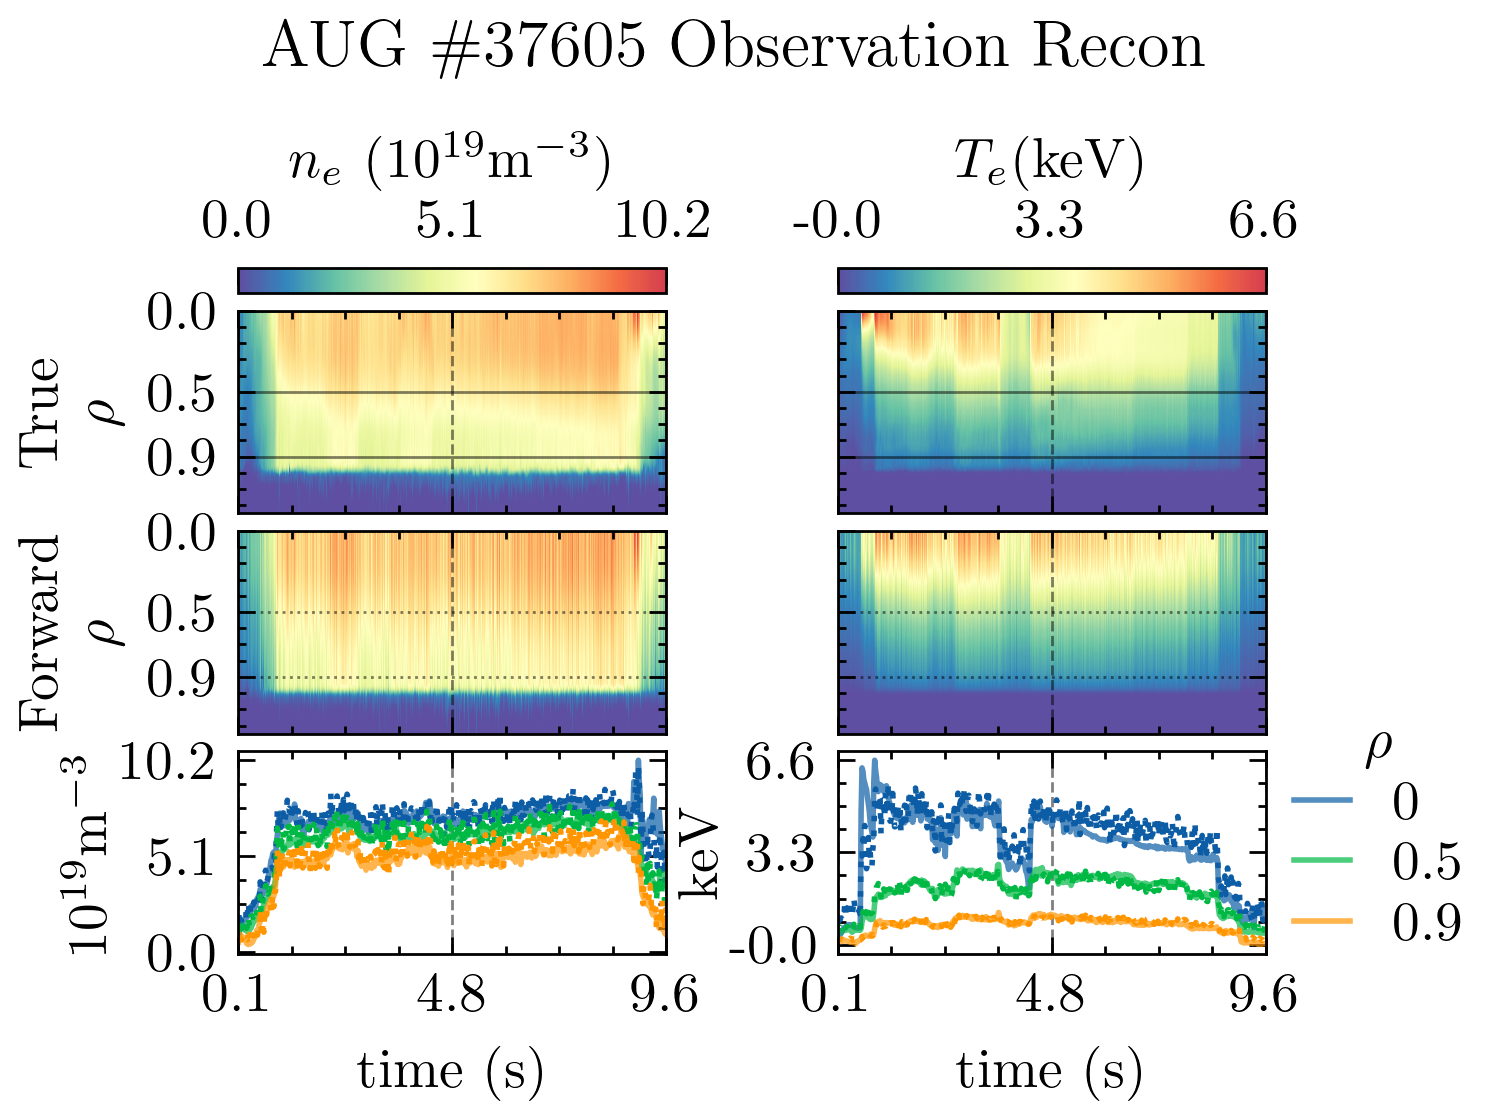

Density Mean 0.34303852005818497 0.3021829847684959
Tempearutre Mean 0.15176713153621438 0.1955862727106452
Density 0.0 0.431 \pm0.344
Temperature 0.0 0.499 \pm0.387

Density 0.5 0.353 \pm0.266
Temperature 0.5 0.137 \pm0.0906

Density 0.9 0.46 \pm0.322
Temperature 0.9 0.0739 \pm0.0491

Density 1.0 0.379 \pm0.294
Temperature 1.0 0.0274 \pm0.0216



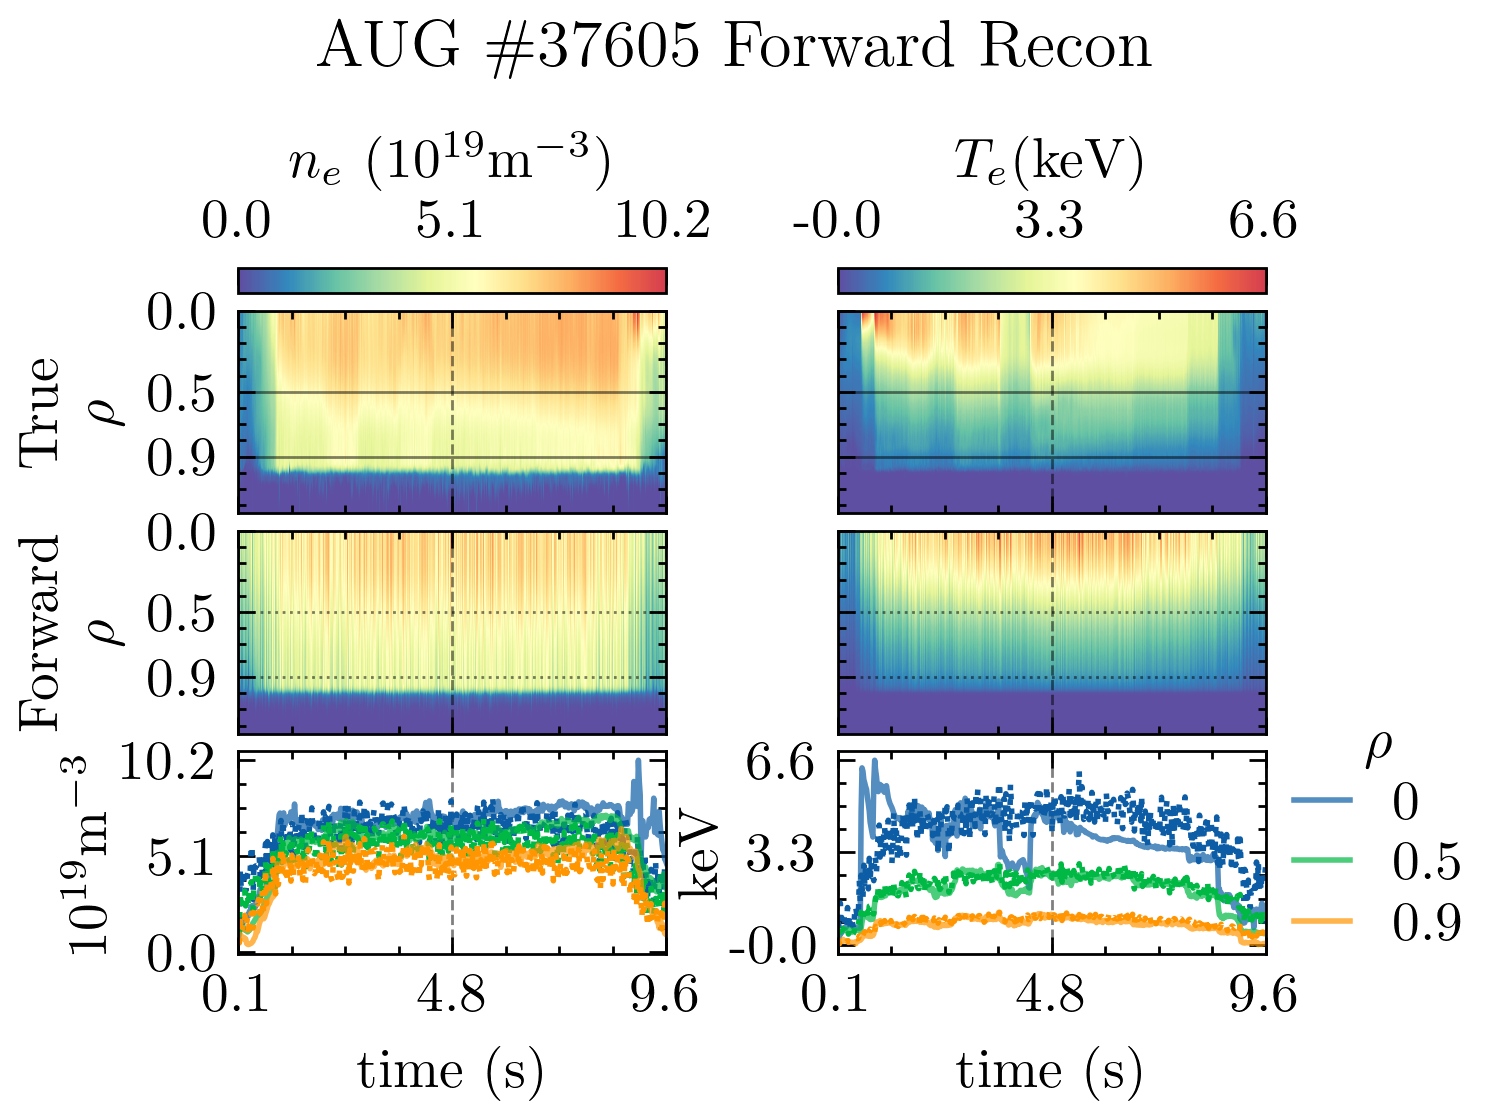

Density Mean 0.6984090519313392 0.6547550858034918
Tempearutre Mean 0.2888861161156661 0.4219723373329003
Density 0.0 1.02 \pm0.906
Temperature 0.0 0.965 \pm0.735

Density 0.5 0.87 \pm0.626
Temperature 0.5 0.247 \pm0.211

Density 0.9 0.698 \pm0.537
Temperature 0.9 0.124 \pm0.0908

Density 1.0 0.664 \pm0.463
Temperature 1.0 0.03 \pm0.0254



In [22]:
shotno = valid_shots[8]
print(shotno)
observation_info, action_info, time, radius, batch_terminal, latent_space_information = shot_prediction(shotno)

data_true, data_pred_obs, data_pred_trans = observation_info
data_x = radius
data_time = time 

to_plot2(data_true, data_pred_obs, data_time, data_x, 'Observation Recon')
to_plot2(data_true, data_pred_trans, data_time, data_x, 'Forward Recon')
